# Evaluation & Comparison: CNN vs SNN vs Loihi Emulator

This notebook evaluates the final **keyword spotting** models on the 6‑class Speech Commands subset:

- Baseline CNN (trained in `baseline_cnn/Baseline_CNN_KWS.ipynb`)
- Converted SNN (from `snn_conversion/SNN_Conversion.ipynb`)
- Tiny Loihi‑emulated classifier built from the CNN head (Nengo + Nengo Loihi)

It assumes the following project layout:

```text
CS-576-Final-Project/
├── baseline_cnn/
│   └── Baseline_CNN_KWS.ipynb
├── snn_conversion/
│   └── SNN_Conversion.ipynb
├── loihi_emulator/
│   └── Loihi_Emulation.ipynb
├── sample_data/
│   └── speech_commands_v0.02/
│       ├── yes/
│       ├── no/
│       ├── go/
│       ├── stop/
│       ├── down/
│       └── up/
├── saved_models/
│   ├── baseline_cnn_kws_vfinal.pt
│   └── snn_kws_beta0.95_T50.pt
└── Evaluation_Comparison.ipynb   ← this file
```

In [11]:
# %%
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nengo
import nengo_loihi

# ---- Project layout ----
PROJECT_ROOT = Path.cwd().resolve()
DATA_DIR = PROJECT_ROOT / "sample_data" / "speech_commands_v0.02"
MODEL_DIR = PROJECT_ROOT / "saved_models"
RESULTS_DIR = PROJECT_ROOT / "results"

RESULTS_DIR.mkdir(exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR exists:", DATA_DIR.exists())
print("MODEL_DIR exists:", MODEL_DIR.exists())
print("RESULTS_DIR exists:", RESULTS_DIR.exists())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PROJECT_ROOT: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project
DATA_DIR exists: True
MODEL_DIR exists: True
RESULTS_DIR exists: True
Using device: cpu


/opt/miniconda3/envs/cs576/lib/python3.10/site-packages/nengo_loihi/version.py:20: UserWarning: This version of `nengo_loihi` has not been tested with your `nengo` version (4.1.0). The latest fully supported version is 3.2.0
  warnings.warn(


In [12]:
# %%
# Six-keyword subset (same as training)
CLASSES = ["yes", "no", "go", "stop", "down", "up"]
NUM_CLASSES = len(CLASSES)

SAMPLE_RATE = 16000
N_MFCC = 40

print("Classes:", CLASSES)

Classes: ['yes', 'no', 'go', 'stop', 'down', 'up']


In [13]:
# %%
# --- CNN architecture (must match training) ---
class CNN_KWS(nn.Module):
    def __init__(self, num_classes: int = 6, flatten_dim: int = 3840):
        super().__init__()
        self.flatten_dim = flatten_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,40,T]
        x = x.unsqueeze(1)           # [B,1,40,T]
        x = self.features(x)
        x = torch.flatten(x, 1)      # [B,F]
        Fdim = x.shape[1]

        # Safety: adapt to expected flatten_dim if needed (crop / pad)
        if Fdim > self.flatten_dim:
            x = x[:, : self.flatten_dim]
        elif Fdim < self.flatten_dim:
            pad = self.flatten_dim - Fdim
            x = F.pad(x, (0, pad))

        x = self.classifier(x)
        return x


# --- SNN wrapper (re-uses CNN features + fc layers) ---
import snntorch as snn
from snntorch import surrogate

spike_grad = surrogate.fast_sigmoid()

class SNN_KWS(nn.Module):
    def __init__(self, base_cnn: CNN_KWS, num_steps: int = 50, beta: float = 0.95):
        super().__init__()
        self.num_steps = num_steps

        # Share CNN parts
        self.features = base_cnn.features
        self.flatten_dim = base_cnn.flatten_dim
        self.fc1 = base_cnn.classifier[0]  # Linear(flatten_dim, 64)
        self.fc2 = base_cnn.classifier[2]  # Linear(64, num_classes)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B,40,T]
        returns: [T,B,NUM_CLASSES] spike trains
        """
        spk2_rec = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        x = x.unsqueeze(1)  # [B,1,40,T]

        for _ in range(self.num_steps):
            cur = self.features(x)
            cur = torch.flatten(cur, 1)
            Fdim = cur.shape[1]

            # safety crop/pad
            if Fdim > self.flatten_dim:
                cur = cur[:, : self.flatten_dim]
            elif Fdim < self.flatten_dim:
                pad = self.flatten_dim - Fdim
                cur = F.pad(cur, (0, pad))

            cur = F.relu(self.fc1(cur))
            spk1, mem1 = self.lif1(cur, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)  # [T,B,C]

In [14]:
# %%
# --- MFCC preprocessing (matched to training as closely as possible) ---
mfcc_transform = nn.Sequential(
    torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        melkwargs={
            "n_fft": 400,
            "hop_length": 160,
            "n_mels": 40,
            "center": False,
        },
    ),
    torchaudio.transforms.AmplitudeToDB(),
)

def wav_to_mfcc(path: Path) -> torch.Tensor:
    """Load WAV with soundfile and convert to normalized MFCC [40, T]."""
    waveform_np, sr = sf.read(str(path))
    # Ensure shape [1, samples]
    if waveform_np.ndim == 1:
        waveform_np = waveform_np[None, :]
    else:
        waveform_np = waveform_np.T[:1, :]  # take first channel

    waveform = torch.tensor(waveform_np, dtype=torch.float32)

    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

    mfcc = mfcc_transform(waveform).squeeze(0)  # [40,T]
    # per-utterance normalization
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
    mfcc = torch.clamp(mfcc, -2.0, 2.0)
    return mfcc


from torch.utils.data import Dataset, DataLoader

class KWSDataset(Dataset):
    def __init__(self, root: Path, classes):
        self.classes = classes
        files = []
        for c in classes:
            cdir = root / c
            files.extend(sorted(cdir.glob("*.wav")))
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        x = wav_to_mfcc(path)  # [40,T]
        label = path.parent.name
        y = self.classes.index(label)
        return x, y


def pad_collate(batch):
    xs, ys = zip(*batch)
    max_T = max(x.shape[1] for x in xs)
    xs_pad = [F.pad(x, (0, max_T - x.shape[1])) for x in xs]
    xs_pad = torch.stack(xs_pad)   # [B,40,T]
    ys = torch.tensor(ys, dtype=torch.long)
    return xs_pad, ys


# Build test loader (we treat entire dataset as "test" for this notebook)
test_dataset = KWSDataset(DATA_DIR, CLASSES)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=pad_collate,
)

print("Num test samples (6 classes):", len(test_dataset))

Num test samples (6 classes): 23377


In [15]:
# %%
cnn_ckpt_path = MODEL_DIR / "baseline_cnn_kws_vfinal.pt"
snn_ckpt_path = MODEL_DIR / "snn_kws_beta0.95_T50.pt"

print("CNN checkpoint exists:", cnn_ckpt_path.exists())
print("SNN checkpoint exists:", snn_ckpt_path.exists())

if not cnn_ckpt_path.exists():
    raise FileNotFoundError(f"Missing CNN checkpoint: {cnn_ckpt_path}")

# --- Load CNN ---
state_dict = torch.load(cnn_ckpt_path, map_location=device)

# infer flatten_dim from checkpoint
flatten_dim_ckpt = state_dict["classifier.0.weight"].shape[1]
print("Flatten dim from checkpoint:", flatten_dim_ckpt)

cnn_model = CNN_KWS(num_classes=NUM_CLASSES, flatten_dim=flatten_dim_ckpt).to(device)
cnn_model.load_state_dict(state_dict)
cnn_model.eval()
print("Loaded CNN model.")

# --- Build & load SNN ---
snn_model = SNN_KWS(cnn_model, num_steps=50, beta=0.95).to(device)

if snn_ckpt_path.exists():
    snn_state = torch.load(snn_ckpt_path, map_location=device)
    snn_model.load_state_dict(snn_state)
    print("Loaded SNN checkpoint from snn_kws_beta0.95_T50.pt")
else:
    print(" No SNN checkpoint found; using CNN weights inside wrapper only.")

snn_model.eval()

CNN checkpoint exists: True
SNN checkpoint exists: True
Flatten dim from checkpoint: 3840
Loaded CNN model.
Loaded SNN checkpoint from snn_kws_beta0.95_T50.pt


SNN_KWS(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3840, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (lif1): Leaky()
  (lif2): Leaky()
)

In [16]:
# %%
@torch.no_grad()
def eval_cnn(model: CNN_KWS, loader, device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)


@torch.no_grad()
def eval_snn(model: SNN_KWS, loader, device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        out_TBC = model(x)            # [T,B,C]
        logits = out_TBC.sum(dim=0)   # [B,C]
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)


cnn_acc = eval_cnn(cnn_model, test_loader, device)
snn_acc = eval_snn(snn_model, test_loader, device)

print(f"CNN test accuracy (6 classes): {cnn_acc*100:.2f}%")
print(f"SNN test accuracy (6 classes): {snn_acc*100:.2f}%")

CNN test accuracy (6 classes): 37.08%
SNN test accuracy (6 classes): 32.84%


In [17]:
# %%
def extract_cnn_features(x: torch.Tensor, model: CNN_KWS) -> torch.Tensor:
    """Return 64-D feature vector after first FC+ReLU for each sample.

    x: [B,40,T] → [B,64]
    """
    with torch.no_grad():
        x_ = x.unsqueeze(1)          # [B,1,40,T]
        h = model.features(x_)       # conv + pool
        h = torch.flatten(h, 1)      # [B,F]
        Fdim = h.shape[1]

        if Fdim > model.flatten_dim:
            h = h[:, : model.flatten_dim]
        elif Fdim < model.flatten_dim:
            pad = model.flatten_dim - Fdim
            h = F.pad(h, (0, pad))

        fc1 = model.classifier[0]
        h = F.relu(fc1(h))           # [B,64]

    return h


# Grab fc2 weights and bias for Loihi classifier
fc2 = cnn_model.classifier[2]
W = fc2.weight.detach().cpu().numpy()   # [6,64]
b = fc2.bias.detach().cpu().numpy()     # [6]

print("fc2 weight shape:", W.shape)
print("fc2 bias shape:", b.shape)


def run_loihi_for_feature(feat_vec: np.ndarray, W: np.ndarray, sim_time: float = 0.1):
    """Run a single 64-D feature through a tiny LIF-based classifier on Loihi emulator.

    feat_vec: [64]
    W:        [6,64]  (same as fc2.weight)
    sim_time: simulation time in seconds

    Returns:
        logits_loihi: [6] numpy array
    """
    assert feat_vec.shape == (64,)
    assert W.shape == (NUM_CLASSES, 64)

    num_classes = W.shape[0]

    with nengo.Network(seed=0) as net:
        inp = nengo.Node(output=lambda t: feat_vec)

        ens = nengo.Ensemble(
            n_neurons=64,
            dimensions=64,
            neuron_type=nengo.LIF(),
        )

        out = nengo.Node(size_in=num_classes)

        # input → ensemble
        nengo.Connection(inp, ens, synapse=None)

        # ensemble neurons → output using W
        nengo.Connection(
            ens.neurons,
            out,
            transform=W,
            synapse=0.01,
        )

        p_out = nengo.Probe(out, synapse=0.01)

    with nengo_loihi.Simulator(net) as sim:
        sim.run(sim_time)
        logits_loihi = sim.data[p_out][-1]

    logits_loihi = np.nan_to_num(logits_loihi)
    return logits_loihi

fc2 weight shape: (6, 64)
fc2 bias shape: (6,)


In [18]:
# %%
from typing import Tuple

def eval_loihi_classifier(
    loader,
    cnn_model: CNN_KWS,
    W: np.ndarray,
    device: torch.device,
    max_samples: int = 50,
    sim_time: float = 0.1,
) -> Tuple[float, float, int]:
    """Compare CNN head vs Loihi classifier on a subset of the test set."""
    cnn_model.eval()

    total = 0
    correct_cnn = 0
    correct_loihi = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch_np = y_batch.numpy()

        # Features [B,64]
        feats = extract_cnn_features(x_batch, cnn_model)
        # CNN head logits [B,6]
        with torch.no_grad():
            logits_cnn = fc2(feats)
            preds_cnn = logits_cnn.argmax(dim=1).cpu().numpy()

        B = feats.size(0)
        for i in range(B):
            feat_np = feats[i].cpu().numpy()
            label = int(y_batch_np[i])

            # CNN prediction
            if preds_cnn[i] == label:
                correct_cnn += 1

            # Loihi prediction
            logits_loihi = run_loihi_for_feature(
                feat_vec=feat_np,
                W=W,
                sim_time=sim_time,
            )
            pred_loihi = int(np.argmax(logits_loihi))

            if pred_loihi == label:
                correct_loihi += 1

            total += 1
            if total >= max_samples:
                cnn_acc = correct_cnn / max(total, 1)
                loihi_acc = correct_loihi / max(total, 1)
                return cnn_acc, loihi_acc, total

    cnn_acc = correct_cnn / max(total, 1)
    loihi_acc = correct_loihi / max(total, 1)
    return cnn_acc, loihi_acc, total


# ---- Run Loihi evaluation on a small subset ----
MAX_LOIHI_SAMPLES = 50
SIM_TIME = 0.1  # 100 ms per sample

cnn_subset_acc, loihi_acc, total_subset = eval_loihi_classifier(
    loader=test_loader,
    cnn_model=cnn_model,
    W=W,
    device=device,
    max_samples=MAX_LOIHI_SAMPLES,
    sim_time=SIM_TIME,
)

print(f"Evaluated Loihi on {total_subset} test samples")
print(f"CNN head accuracy on same subset: {cnn_subset_acc*100:.2f}%")
print(f"Loihi classifier accuracy:        {loihi_acc*100:.2f}%")

/opt/miniconda3/envs/cs576/lib/python3.10/site-packages/nengo_loihi/builder/ensemble.py:164: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  warnings.warn(
/opt/miniconda3/envs/cs576/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Evaluated Loihi on 50 test samples
CNN head accuracy on same subset: 44.00%
Loihi classifier accuracy:        16.00%


,model,dataset,accuracy,notes
0,CNN,test_full_6classes,0.370792,End-to-end MFCC → CNN
1,"SNN (beta=0.95, T=50)",test_full_6classes,0.328442,Converted from CNN with snnTorch
2,CNN,test_subset_50,0.440000,Same subset as Loihi evaluation
3,Loihi emulator,test_subset_50,0.160000,"64→6 LIF classifier, sim_time=0.1s"


Saved results to:
   /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project/results/eval_comparison_results.csv
   /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project/results/eval_comparison_results.json


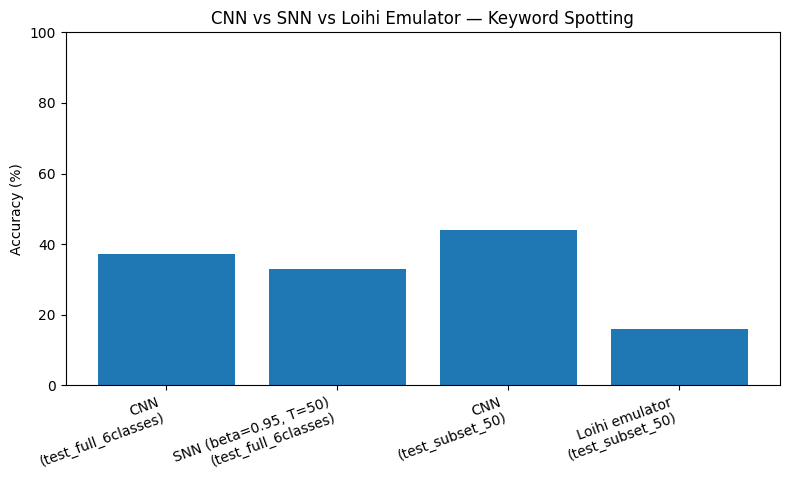

Saved bar plot to: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project/results/eval_comparison_bar.png


In [19]:
# %%
# Aggregate results into a DataFrame
results = [
    {
        "model": "CNN",
        "dataset": "test_full_6classes",
        "accuracy": cnn_acc,
        "notes": "End-to-end MFCC → CNN",
    },
    {
        "model": "SNN (beta=0.95, T=50)",
        "dataset": "test_full_6classes",
        "accuracy": snn_acc,
        "notes": "Converted from CNN with snnTorch",
    },
    {
        "model": "CNN",
        "dataset": f"test_subset_{total_subset}",
        "accuracy": cnn_subset_acc,
        "notes": "Same subset as Loihi evaluation",
    },
    {
        "model": "Loihi emulator",
        "dataset": f"test_subset_{total_subset}",
        "accuracy": loihi_acc,
        "notes": f"64→6 LIF classifier, sim_time={SIM_TIME}s",
    },
]

df = pd.DataFrame(results)
display(df)

# Save to disk
csv_path = RESULTS_DIR / "eval_comparison_results.csv"
json_path = RESULTS_DIR / "eval_comparison_results.json"

df.to_csv(csv_path, index=False)
df.to_json(json_path, orient="records", indent=2)

print("Saved results to:")
print("  ", csv_path)
print("  ", json_path)

# Simple bar plot of accuracies
plt.figure(figsize=(8, 5))
x_labels = [f"{r['model']}\n({r['dataset']})" for r in results]
acc_vals = [r["accuracy"] * 100 for r in results]

plt.bar(range(len(acc_vals)), acc_vals)
plt.xticks(range(len(acc_vals)), x_labels, rotation=20, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("CNN vs SNN vs Loihi Emulator — Keyword Spotting")
plt.ylim(0, 100)
plt.tight_layout()

plot_path = RESULTS_DIR / "eval_comparison_bar.png"
plt.savefig(plot_path, dpi=150)
plt.show()

print("Saved bar plot to:", plot_path)